In [15]:
from IPython.display import clear_output
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

from gmphd_precise import mtt_phd
from utils import *

In [16]:
# Measurement parameters
dim = 2
dt = 1.0
num_steps = 50

birth_prob = 0.2
death_prob = 0.005

det_prob = 0.9
clutter_rate = 3

pos_bounds = (-30, 30)
vel_bounds = (-1, 1)

area = (-100, 100)

[array([25.98493552, 12.27748411, -0.11686796,  0.22141196]), array([-20.34955743, -22.97402106,   0.71450091,   0.06078582]), array([-9.45754158,  2.68039964, -0.08524922, -0.52822196]), array([-26.15885853, -22.06791157,  -0.16785318,  -0.4350701 ]), array([0.59184853, 7.41532989, 0.6374818 , 0.01126425]), array([ 29.01374317, -12.57991263,   0.15272799,   0.07435278]), array([-1.52692175, 21.17317195,  0.58297437,  0.6360408 ]), array([ 8.63638366, -1.64306548, -0.44064514, -0.4285756 ]), array([ 14.07572744, -15.67751145,   0.85198692,   0.41497351]), array([-29.09051696,  14.01151397,  -0.18079104,  -0.37748394]), array([-18.79874602,   9.00219266,   0.87559843,   0.10174432]), array([-2.70850624, 19.9841509 , -0.10680091, -0.16267766]), array([ 7.97870095, 18.3716157 , -0.87143221,  0.58458245]), array([-28.80128822,  21.10911837,   0.53100824,  -0.81983139])]


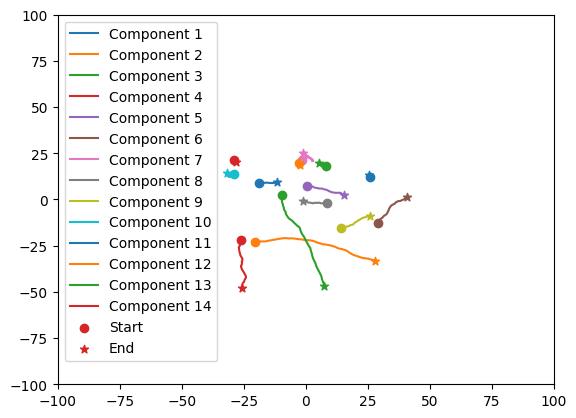

In [17]:
# generate ground truth data
F = create_state_matrix(dt, dim)
Q = np.identity(F.shape[0]) * 0.01

truths = simulate_motion(F, Q, num_steps=num_steps, birth_prob=birth_prob, death_prob=death_prob, pos_bounds=pos_bounds, vel_bounds=vel_bounds)
colors = []
for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    line = plt.plot(*pos[:,:2].T, label=f'Component {i + 1}')
    colors.append(line[0].get_color())
    plt.xlim(*area)
    plt.ylim(*area)
starts = []
ends = []
for i, state in truths.items():
    temp = [s for s in state if s is not None]
    starts.append(temp[0])
    ends.append(temp[-1])
print(starts)
for i, start in enumerate(starts):
    plt.scatter(*start[:2], marker='o', color=colors[i], label='Start')
for i, end in enumerate(ends):
    plt.scatter(*end[:2], marker='*', color=colors[i], label='End')

handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys())

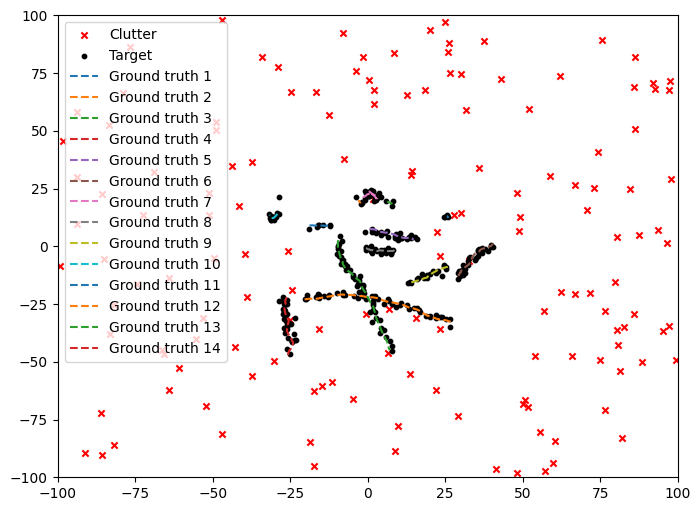

In [18]:
H = create_measurement_matrix(dim)
R = np.identity(H.shape[0]) * 0.75

all_measurements = simulate_measurement(truths, H, R, num_steps=num_steps, det_prob=det_prob, clutter_rate=clutter_rate, area=area)

# Setup
component_ids = sorted({i for measurements in all_measurements.values() for i, _ in measurements if i is not None})
num_steps = max(all_measurements.keys()) + 1

# Initialize trace for ground truths
trace_pos = {i: [] for i in truths}
all_clutter = []
all_target_measurements = []

for step in range(num_steps):
    measurements = all_measurements.get(step, [])

    # Accumulate measurements
    for i, measurement in measurements:
        if i is None:
            all_clutter.append(measurement)
        else:
            all_target_measurements.append((i, measurement))

    # Update ground truth traces
    for i, state in truths.items():
        if state[step] is not None:
            trace_pos[i].append(state[step][:2])
        else:
            trace_pos[i].append([np.nan, np.nan])

    # Plotting
    clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    # Plot all clutter points so far
    if all_clutter:
        clutter_array = np.array(all_clutter)
        plt.scatter(clutter_array[:, 0], clutter_array[:, 1], c='red', marker='x', label='Clutter', s=20)

    # Plot all target measurements so far
    for i in component_ids:
        points = [m for j, m in all_target_measurements if j == i]
        if points:
            pts = np.array(points)
            plt.scatter(pts[:, 0], pts[:, 1], color='black', label='Target', s=10)

    # Plot ground truth trajectories
    for i, pos_list in trace_pos.items():
        pos = np.array(pos_list)
        plt.plot(pos[:, 0], pos[:, 1], linestyle='dashed', label=f'Ground truth {i + 1}')

    # Clean up legend
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    plt.legend(unique.values(), unique.keys())

    plt.xlim(*area)
    plt.ylim(*area)
    plt.show()

    time.sleep(0.05)

In [19]:
print("F")
print(F)
print("Q")
print(Q)
print("H")
print(H)
print("R")
print(R)

F
[[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Q
[[0.01 0.   0.   0.  ]
 [0.   0.01 0.   0.  ]
 [0.   0.   0.01 0.  ]
 [0.   0.   0.   0.01]]
H
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]]
R
[[0.75 0.  ]
 [0.   0.75]]


In [20]:
# get initial truths
init_truths = []
for states in truths.values():
    if states[0] is not None:
        init_truths.append(states[0])
    
init_truths = np.array(init_truths)

num_components = len(init_truths)

# assume each component has the same weight
component_weight = 1e-3

# the variance of pos and vel
pos_var = 10
vel_var = 5

# each component assumed to start at a random (x, y) ~ U([-50, 50] x [-50, 50])
start_bounds = (-50, 50)

w = [component_weight] * num_components
# m = init_truths.copy()
m = []
for i in range(num_components):
    # m.append(np.random.uniform(start_bounds[0], start_bounds[1], size=(dim,)))
    m.append(np.array([
            *np.random.uniform(*start_bounds, 2),
            # initial velocity (dx, dy) ~ U(-2, 2) x U(-2, 2)
            0, 
            0
    ]))
m = np.array(m)
P = np.array([np.diag([pos_var, pos_var, vel_var, vel_var])**2 for _ in range(num_components)])

In [21]:
print("Initial weights:")
print(w)
print("Initial means:")
print(m)
print("Initial covariances:")
print(P)

Initial weights:
[0.001, 0.001, 0.001]
Initial means:
[[-13.87706377 -30.43090395   0.           0.        ]
 [-42.30376674  18.50592779   0.           0.        ]
 [ 36.46925255  -9.91567016   0.           0.        ]]
Initial covariances:
[[[100   0   0   0]
  [  0 100   0   0]
  [  0   0  25   0]
  [  0   0   0  25]]

 [[100   0   0   0]
  [  0 100   0   0]
  [  0   0  25   0]
  [  0   0   0  25]]

 [[100   0   0   0]
  [  0 100   0   0]
  [  0   0  25   0]
  [  0   0   0  25]]]


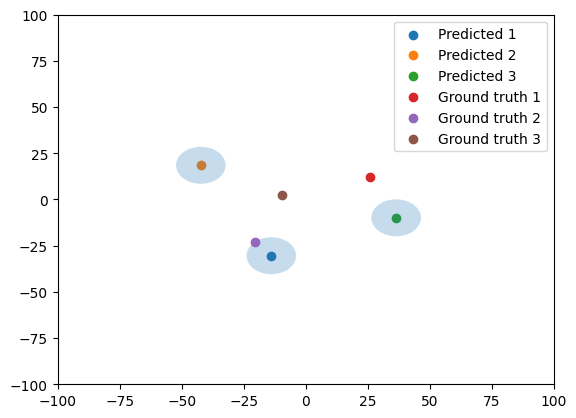

In [22]:
fig, ax = plt.subplots()
for i in range(len(w)):
    pos = m[i][:2]
    cov = P[i][:2, :2]
    eigvals, eigvecs = np.linalg.eig(cov)
    a = eigvals.argsort()[::-1]
    eigvals = eigvals[a]
    unc = patches.Ellipse(pos, 2 * np.sqrt(eigvals[0]), 2 * np.sqrt(eigvals[1]), angle=0, alpha=0.25)
    ax.scatter(pos[0], pos[1], label=f'Predicted {i + 1}')
    ax.add_patch(unc)
    ax.set_xlim(*area)
    ax.set_ylim(*area)

for i in range(len(init_truths)):
    pos = init_truths[i][:2]
    ax.scatter(*pos, label=f'Ground truth {i + 1}')
plt.legend()

In [23]:
# print(all_measurements)
# all_measurements.pop(0)
# print(all_measurements)

In [24]:
# initialize the filter
filter = mtt_phd(
    weights=w,
    position=m,
    p_cov=P,
    num_components=num_components,
    measurement=all_measurements,
    state_transition_matrix=F,
    process_noise_matrix=Q,
    measurement_matrix=H,
    measurement_noise=R,
    num_steps=len(all_measurements),
    detection_probability=det_prob,
    clutter_intensity=clutter_rate/(area[1] - area[0])**2,
    merging_threshold = 5.0,
    truncation_threshold = 1e-8, # make sure squared
    threshold_weight= 0.1,
    new_birth_weight=0.25,
    survival_prob=0.995,
    max_components=100,
)

In [25]:
history = filter.run()
print(history)

{0: [], 1: [], 2: [[-19.181216707115574, -21.769082543751846, 0.23185504745951482, 0.3510460460686418]], 3: [], 4: [[24.879504978879595, 12.786073104845434, 0.612842368211637, 0.7471818267218278], [-9.614967631027504, 0.34477484707978145, -0.17585477273420996, -0.5827271173650033]], 5: [[-9.505302383141412, -0.23480069511064, -0.14718404665897664, -0.5690714795060604]], 6: [[-9.615924404361126, -1.1030085983150393, -0.17145377244451032, -0.6031082455007827]], 7: [[-8.722954769104257, -1.9907531437463588, 0.011893384469336143, -0.5600371662821403]], 8: [[-9.30914364357693, -4.04327656772958, -0.22467715429961446, -0.814943150080453]], 9: [[-9.711330545371938, -3.660618197586757, -0.08479095338628209, -0.49925310737560635]], 10: [[-8.949770488704663, -4.443608121682825, 0.2343511720752408, -0.5381722409244771], [-13.194825685771015, -21.886024367662547, 0.7695915743655699, -0.1796342670634582], [-28.330572409240162, -24.156144270795114, -1.0993214475926065, -1.4590956988295483]], 11: [[-

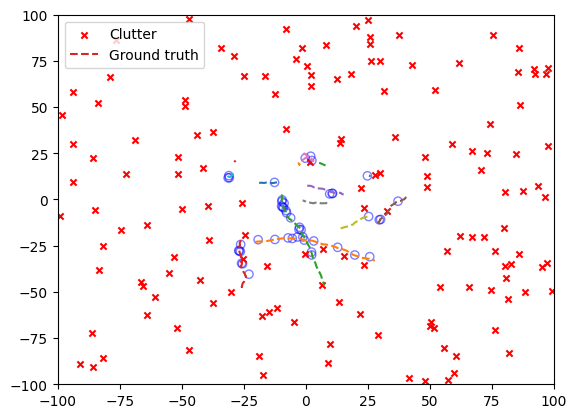

In [26]:
pos = []
for state in history.values():
    if len(state) > 0:
        pos.append(state[0][:2])
pos = np.array(pos)
plt.scatter(*pos.T, facecolors='none', edgecolors='blue', alpha=0.5)
plt.xlim(*area)
plt.ylim(*area)

for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    plt.plot(*pos[:,:2].T, linestyle='dashed', label=f'Ground truth')

for measurements in all_measurements.values():
    for i, measurement in measurements:
        if i is None:
            plt.scatter(measurement[0], measurement[1], c='red', marker='x', label='Clutter', s=20)

handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
order = np.argsort(list(unique.keys()))
plt.legend([list(unique.values())[i] for i in order], [list(unique.keys())[i] for i in order])

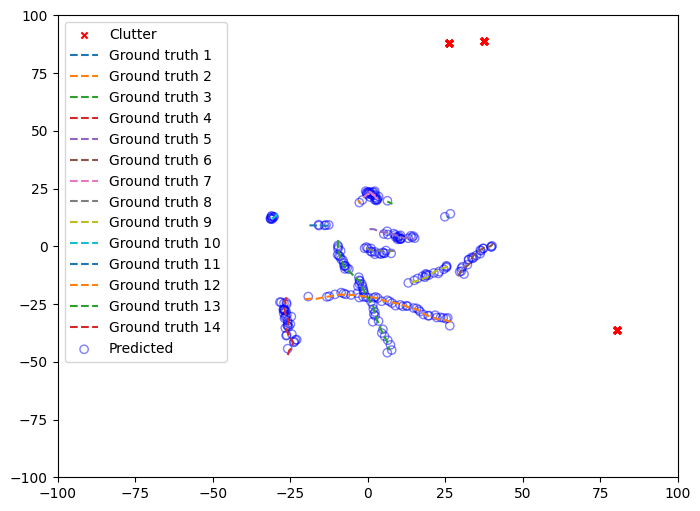

In [28]:
# pos = []
all_clutter = []
all_pos = []

for i in range(num_steps):
    measurements = all_measurements.get(step, [])
    # Plotting
    clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    for j, state in enumerate(history[i]):
        if state is not None:
            pos = state[:2]
            all_pos.append(pos)
        else:
            all_pos.append([np.nan, np.nan])
    # Accumulate measurements
    for i, measurement in measurements:
        if i is None:
            all_clutter.append(measurement)

    # Update ground truth traces
    for i, state in truths.items():
        if state[step] is not None:
            trace_pos[i].append(state[step][:2])
        else:
            trace_pos[i].append([np.nan, np.nan])


    # Plot all clutter points so far
    if all_clutter:
        clutter_array = np.array(all_clutter)
        plt.scatter(clutter_array[:, 0], clutter_array[:, 1], c='red', marker='x', label='Clutter', s=20)

    # Plot ground truth trajectories
    for i, pos_list in trace_pos.items():
        pos = np.array(pos_list)
        plt.plot(pos[:, 0], pos[:, 1], linestyle='dashed', label=f'Ground truth {i + 1}')

    for p in all_pos:
        plt.scatter(*p, facecolors='none', edgecolors='blue', alpha=0.5, label='Predicted')

    # Clean up legend
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    plt.legend(unique.values(), unique.keys())

    plt.xlim(*area)
    plt.ylim(*area)
    plt.show()

    time.sleep(0.05)